In [1]:
import psycopg2 as ps
import pandas as pd
import numpy as np

import requests
import json
import io

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn.metrics import ndcg_score
import random

import chgk_api as cha

# настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

In [2]:
# настройки

# количество вопросов "виртуальной перестрелки", кототорое планируем моделировать
test_distnce = 8

In [3]:
def make_metric(df, pred, target, k=5):
    """
    Функция для точности прогноза. 
    Сейчас это ndcg_score https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ndcg_score.html
    """
    df = df.sort_values(by=pred)
    y_true = np.array([df[target]])
    y_pred = np.array([df[pred]])
    return ndcg_score(y_true, y_pred, k=k)


def get_target(df):
    """
    Функция для расчёта целевой метрики
    Сейчас - это ранг суммы взятых с усреднением
    """
    totals_df = df.groupby(['tourn_id', 'team_id']).agg(
        target_question = ('qv_result', 'sum'),
    ).reset_index()
    totals_df['target'] = totals_df.groupby(['tourn_id'])['target_question'].rank(method='average', ascending=False)

    return totals_df

def get_current_taken_forecast(df, qv_num):
    """
    Функция для расчёта прогноза "по взятым".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num вопроса
    """
    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id']).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    totals_df = get_target(df)

    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    gr_df['current_place'] = gr_df.groupby(['tourn_id'])['current_res'].rank(method='average', ascending=False)
    gr_df = gr_df.sort_values(by='target_question', ascending=False)

    return gr_df

def get_current_qv_rating_forecast(df, qv_num):
    """
    Функция для расчёта прогноза "по рейтингу взятых вопросов".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num по рейтингу взятых
    """
    # статистика по вопросам
    qv_stat_df = df.groupby(['tourn_id', 'question_num']).agg(
        taked = ('qv_result', 'sum'),
        total = ('qv_result', 'count'),
    ).reset_index()
    # рейтинг вопроса - количество команд, которые его не взяли
    qv_stat_df['qv_rating'] = qv_stat_df['total'] - qv_stat_df['taked']

    qv_df = df.merge(qv_stat_df, 'left', on=['tourn_id', 'question_num'])
    # вопросный рейтинг команды - суммарный рейтинг вопросов, которые она взяла  
    qv_df['rating'] = qv_df['qv_rating'] * qv_df['qv_result'] 

    gr_df = qv_df[qv_df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id']).agg(
        current_rating = ('rating', 'sum'),
    ).reset_index()
    gr_df['rating_place'] = gr_df.groupby(['tourn_id'])['current_rating'].rank(method='average', ascending=False)

    totals_df = get_target(df)

    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])

    return gr_df

In [4]:
# смотрим на примере одного турнира
tourn_df, question_df, players_df = cha.get_tourn_result(10707)
qv_stat = cha.tourn_stat(question_df)

200


In [5]:
# собираем нужный датасет
work_df = qv_stat.merge(tourn_df[['tourn_id', 'team_id', 'predictedPosition', 'position']], 'left', on=['tourn_id', 'team_id'])
work_df['qv_result'] = work_df['qv_result'].astype('int')

In [6]:
work_df.sample(3)

,tourn_id,team_id,numqv,question_num,qv_result,predictedPosition,position
3005,10707,336,90,43,0,39,25.5
5853,10707,54517,90,83,0,51,31.5
3132,10707,50319,90,45,1,26,9.0


In [7]:
# проверяем работу функций
get_current_taken_forecast(work_df, 12)[0:4]

,tourn_id,team_id,current_res,target_question,target,current_place
39,10707,49804,10,75,1.0,1.0
62,10707,86405,6,61,2.5,26.5
11,10707,4109,8,61,2.5,5.0
54,10707,71595,8,60,4.5,5.0


In [8]:
get_current_qv_rating_forecast(work_df, 12)[0:4]

,tourn_id,team_id,current_rating,rating_place,target_question,target
0,10707,222,26,69.0,34,56.0
1,10707,294,121,45.0,28,65.5
2,10707,312,114,47.0,39,44.0
3,10707,336,111,48.0,45,25.5


In [9]:
n = 100
metric_test_df = pd.DataFrame(range(1, n+1))
metric_test_df.columns = ['target']
places = list(range(1, len(metric_test_df)+1))
random.shuffle(places)
metric_test_df['random'] = places

metric_test_df = metric_test_df.sort_values(by='random')
make_metric(metric_test_df, 'target', 'random', k=n)

0.8195864982217097

<Axes: xlabel='num_of_qv'>

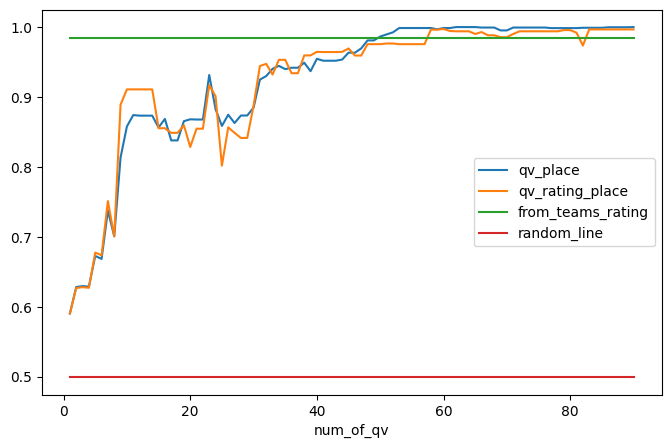

In [31]:
# а теперь проход по всем вопроса турнира
res_lst = []
qv_rating_lst = []
for i in range(1, work_df['numqv'].values[0]+1):
    qv_forecast_df = get_current_taken_forecast(work_df, i)
    rating_forecast_df = get_current_qv_rating_forecast(work_df, i)
    res_lst.append(make_metric(qv_forecast_df, 'current_place', 'target'))
    qv_rating_lst.append(make_metric(rating_forecast_df, 'rating_place', 'target'))

res_df = pd.DataFrame(res_lst)
res_df.columns = ['qv_place']
res_df['qv_rating_place'] = qv_rating_lst
res_df['num_of_qv'] = range(1, len(res_df)+1)

# добавляем бенчмарки
# рейтинг команд
res_df['from_teams_rating'] = make_metric(tourn_df, 'predictedPosition', 'position')

# его величество рандом
places = list(range(1, len(tourn_df)+1))
random.shuffle(places)
tourn_df['random'] = places
res_df['random_line'] = make_metric(tourn_df, 'random', 'position')

res_df.set_index('num_of_qv').plot()

In [33]:
# в качестве прогноза берём ситуацию перед начало "виртуальной перестрелки"
res_df[res_df['num_of_qv'] == work_df['numqv'].values[0] - test_distnce]

,qv_place,qv_rating_place,num_of_qv,from_teams_rating,random_line
81,0.999013,0.97352,82,0.983832,0.499226
